─── Cell 1: Changelog & Context ─────────────────────────────────────────────
APD_analysis.ipynb — v1.0
- Implements ROI‑level APD50 & APD90 computation
- Computes APD50/APD90 ratio
- Provides mask + plotting helper to gray‑out flagged events

In [6]:
# ─── Cell 2: Imports ────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
from itertools import groupby
import os
import io

In [ ]:
# ─── Cell 3: Load Excel Workbook & Inspect Sheets ──────────────────────────
excel_path = "C://Users//Anhnh//OneDrive//Documents//Git//Sup_Rep_BeRST_pilot_excel.xlsx"
xls = pd.ExcelFile(excel_path)
print("Found sheets:", xls.sheet_names)

In [7]:
# ─── Cell 4: Core APD Utility Functions ────────────────────────────────────
def find_depol_start(trace, time, threshold=0.1):
    """
    Find the index where the trace first crosses the depolarization threshold.
    threshold: fraction of the upstroke amplitude (default 0.1 = 10%)
    """
    baseline = np.min(trace)
    peak_idx = np.argmax(trace)
    amp = trace[peak_idx] - baseline
    candidates = np.where(trace > baseline + amp * threshold)[0]
    return candidates[0] if candidates.size > 0 else None

def find_repol_crossing(trace, time, perc=50):
    """
    Find the index where the trace repolarizes to `perc`% of its amplitude.
    perc: percentage for APD calculation (e.g. 50 or 90)
    """
    baseline = np.min(trace)
    peak_idx = np.argmax(trace)
    amp = trace[peak_idx] - baseline
    # repolarization threshold at (100 - perc)% of the upstroke
    repol_threshold = baseline + amp * (1 - perc / 100)
    candidates = np.where(trace[peak_idx:] < repol_threshold)[0]
    return (peak_idx + candidates[0]) if candidates.size > 0 else None

def compute_apd(trace, time, perc=50, start_thresh=0.1):
    """
    Compute the Action Potential Duration (APD) at `perc`% repolarization for one ROI.
    Returns the time difference between depolarization start and repolarization crossing.
    """
    start_idx = find_depol_start(trace, time, threshold=start_thresh)
    repol_idx = find_repol_crossing(trace, time, perc=perc)
    if start_idx is None or repol_idx is None:
        return np.nan
    return time[repol_idx] - time[start_idx]

def compute_apd_all(traces, time, perc=50, start_thresh=0.1):
    """
    Compute APD50 or APD90 for all ROIs in one go.
    traces: 2D array (n_timepoints x n_rois)
    Returns a 1D array of APD values per ROI.
    """
    return np.array([
        compute_apd(traces[:, i], time, perc, start_thresh)
        for i in range(traces.shape[1])
    ])

def analyze_roi_signal(time, signal, sample_name, roi_label):
    # Clean and prepare
    signal = pd.to_numeric(signal, errors='coerce').dropna().values
    time = time[: len(signal)]

    # Normalize ΔF/Fmin
    Fmin = np.min(signal)
    normalized = (signal - Fmin) / Fmin

    # Smooth
    smoothed = gaussian_filter1d(normalized, sigma=1)

    # Initial slope (derivative)
    slope_initial = np.gradient(smoothed, time)

    # Photobleaching correction via “flat” points
    flat_thresh = np.percentile(np.abs(slope_initial), 20)
    flat_idxs = np.where(np.abs(slope_initial) < flat_thresh)[0]
    if flat_idxs.size >= 2:
        flat_times = time[flat_idxs]
        flat_vals = smoothed[flat_idxs]
        bleach_curve = np.interp(time, flat_times, flat_vals)
        bleach_curve[bleach_curve == 0] = 1
        smoothed = smoothed / bleach_curve

    # Recompute slope
    slope = np.gradient(smoothed, time)

    # Dynamic thresholds
    s_max, s_med = smoothed.max(), np.median(smoothed)
    dr = s_max - s_med
    rising_thresh = 0.05 * dr
    depol_thresh  = 0.02 * dr

    # Detect rising‐edge groups
    edges = np.where(slope > rising_thresh)[0]
    groups = []
    for _, grp in groupby(enumerate(edges), lambda x: x[0] - x[1]):
        idxs = [i for _, i in grp]
        if len(idxs) >= 5:
            groups.append(idxs)

    # Candidate peaks
    peaks = []
    for g in groups:
        start = g[0]
        end   = min(g[-1] + 20, len(smoothed))
        peaks.append(np.argmax(smoothed[start:end]) + start)

    # De‐dupe close peaks
    filt_peaks = []
    for p in peaks:
        if not filt_peaks or p - filt_peaks[-1] > 40:
            filt_peaks.append(p)

    # Extract metrics
    results = []
    for pk in filt_peaks:
        # Find depolarization start
        window = range(max(0, pk - 100), pk)
        cand   = [i for i in window if slope[i] < depol_thresh]
        if not cand:
            continue
        start_idx = cand[-1]

        # Baseline & amplitude
        pre      = smoothed[max(0, start_idx - 50) : start_idx]
        baseline = pre.min()
        peak_val = smoothed[pk]
        amp      = peak_val - baseline

        # APD90
        lvl90 = baseline + 0.1 * amp
        repol90_idx = next((i for i in range(pk + 1, len(smoothed)) 
                            if smoothed[i] <= lvl90), None)
        if repol90_idx is None:
            continue
        apd90 = time[repol90_idx] - time[start_idx]

        # APD50
        lvl50 = baseline + 0.5 * amp
        repol50_idx = next((i for i in range(pk + 1, len(smoothed)) 
                            if smoothed[i] <= lvl50), None)
        if repol50_idx is None:
            continue
        apd50 = time[repol50_idx] - time[start_idx]

        # Ratio & upstroke
        ratio50_90 = apd50 / apd90 if apd90 > 0 else np.nan
        upstroke   = time[pk] - time[start_idx]

        results.append({
            'Depolarization_Start_Time_s': start_idx and time[start_idx],
            'Peak_Time_s':               time[pk],
            'Amplitude':                 amp,
            'APD50_s':                   apd50,
            'APD90_s':                   apd90,
            'APD50_90_Ratio':            ratio50_90,
            'Upstroke_Time_s':           upstroke,
            'Repolarization_Time_s':     time[repol90_idx],
            'Repolarization_Level':      smoothed[repol90_idx],
        })

    df_res = pd.DataFrame(results)

    # v6 filters
    if not df_res.empty:
        # Upstroke filter (v6)
        df_res = df_res[df_res['Upstroke_Time_s'] > 0.06].reset_index(drop=True)
        # APD90 outlier filter (new v6)
        med90   = df_res['APD90_s'].median()
        df_res  = df_res[df_res['APD90_s'] < 1.8 * med90].reset_index(drop=True)

    # Ensure column order
    cols = ['Depolarization_Start_Time_s','Peak_Time_s','Amplitude',
            'APD50_s','APD90_s','APD50_90_Ratio','Upstroke_Time_s',
            'Repolarization_Time_s','Repolarization_Level']
    df_res = df_res.reindex(columns=cols)

    # Plot
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(time, smoothed, label='Smoothed ΔF/Fmin')
    for t in df_res['Peak_Time_s']:
        ax.axvline(t, color='green', linestyle='--', alpha=0.8)
    for t in df_res['Depolarization_Start_Time_s']:
        ax.axvline(t, color='black', linestyle='--', alpha=0.5)
    for row in df_res.itertuples():
        ax.hlines(y=row.Repolarization_Level,
                  xmin=row.Depolarization_Start_Time_s,
                  xmax=row.Repolarization_Time_s,
                  color='red', linewidth=2, alpha=0.8)
    ax.set_title(f"{sample_name} | {roi_label}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("ΔF/Fmin")
    ax.grid(True)
    fig.tight_layout()

    return sample_name, roi_label, df_res, fig

C:\Users\Anhnh\AppData\Local\Temp\ipykernel_17772\501313216.py:168: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10,4))


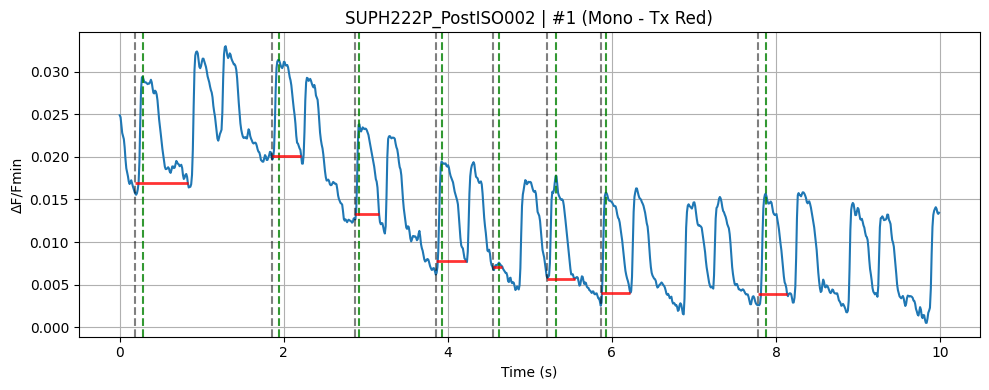

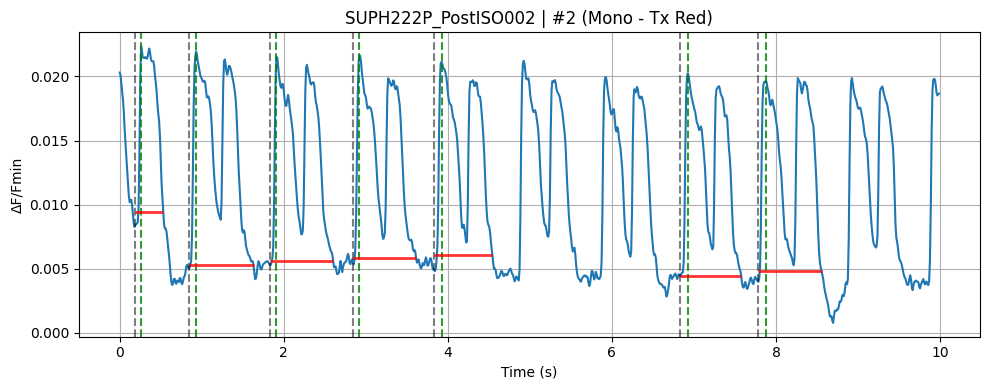

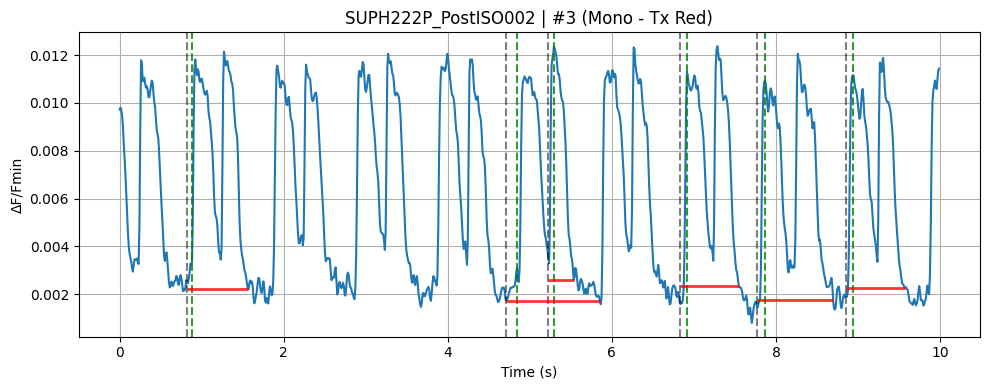

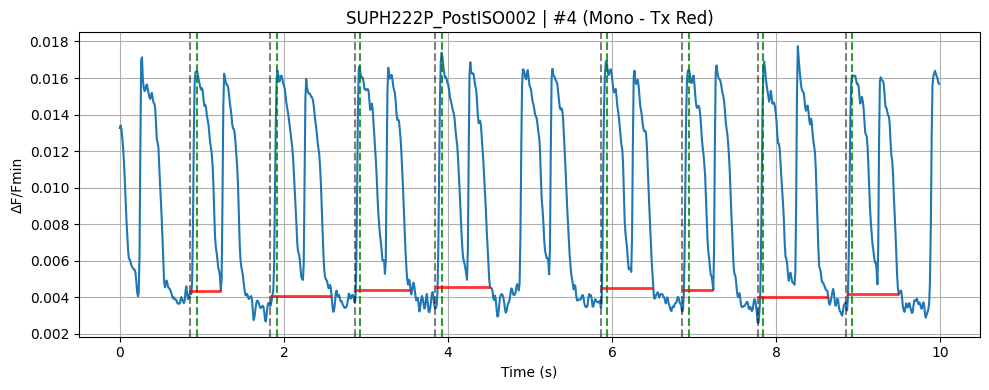

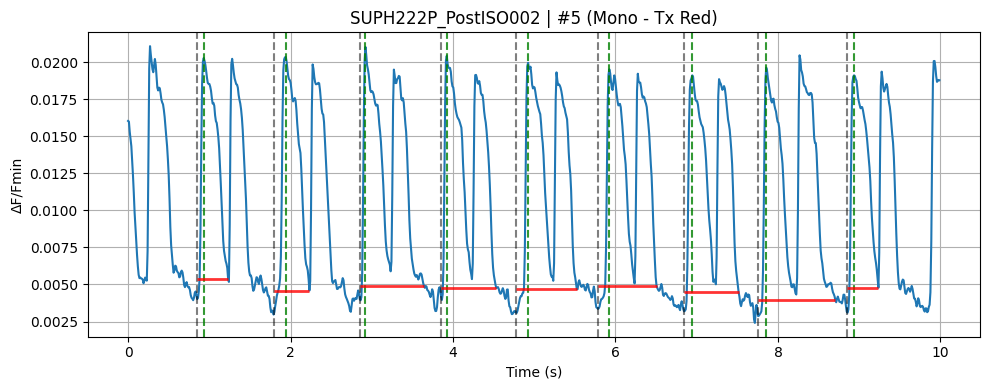

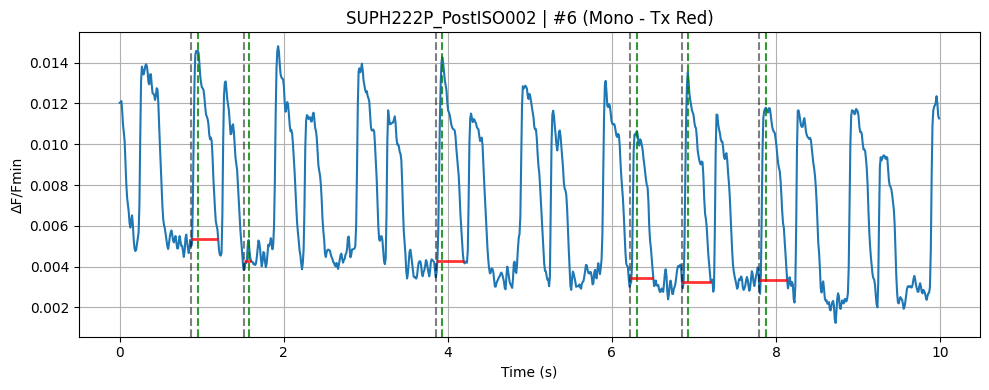

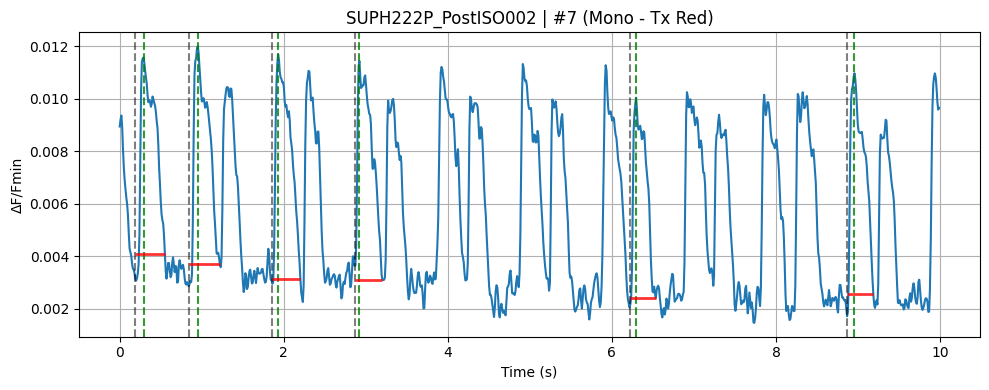

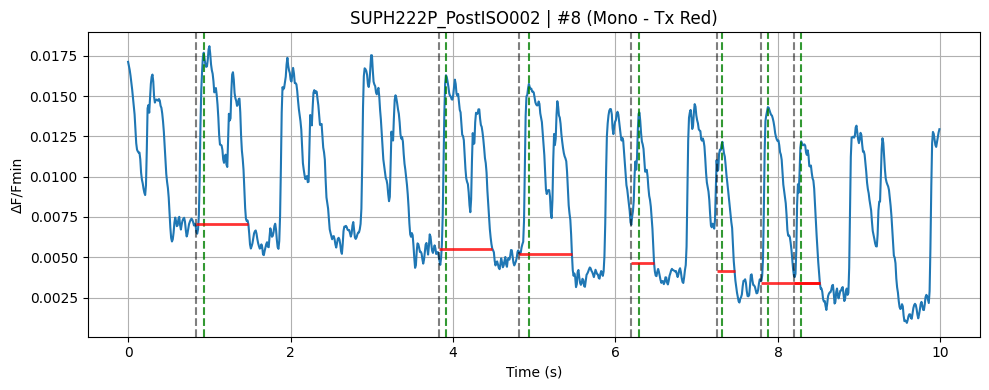

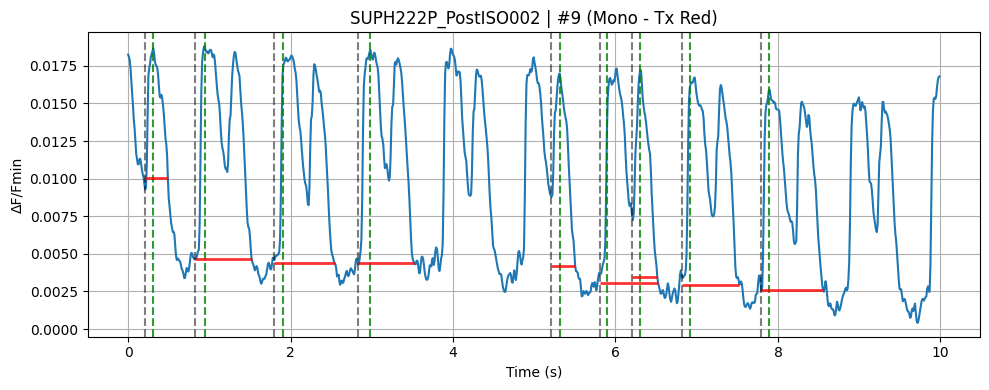

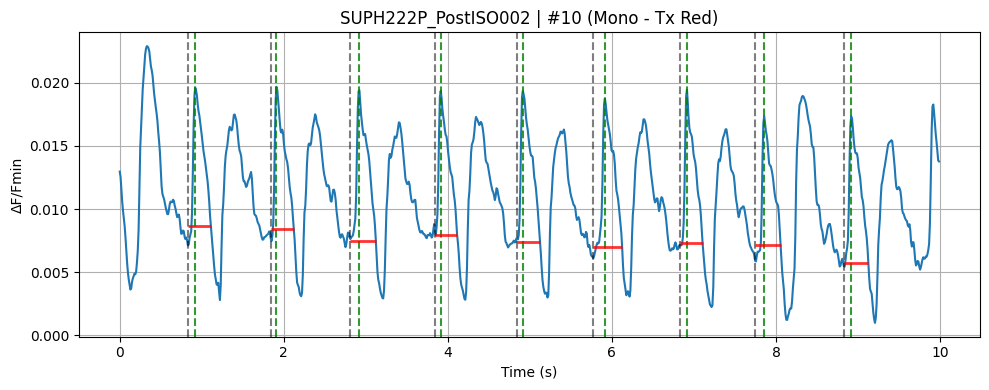

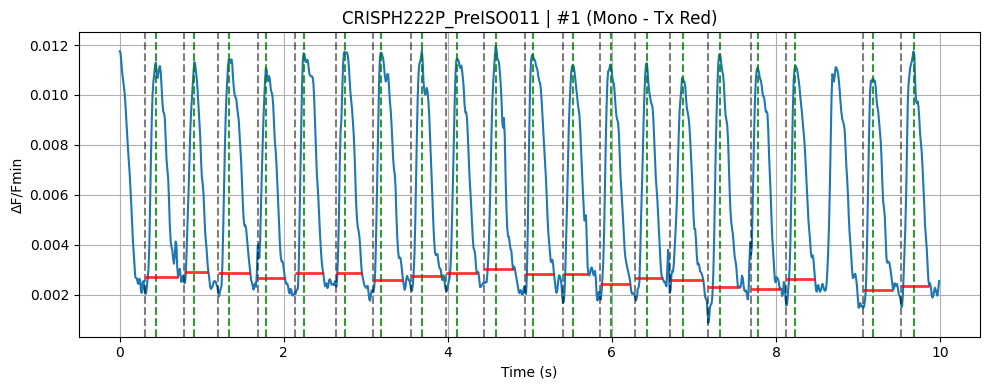

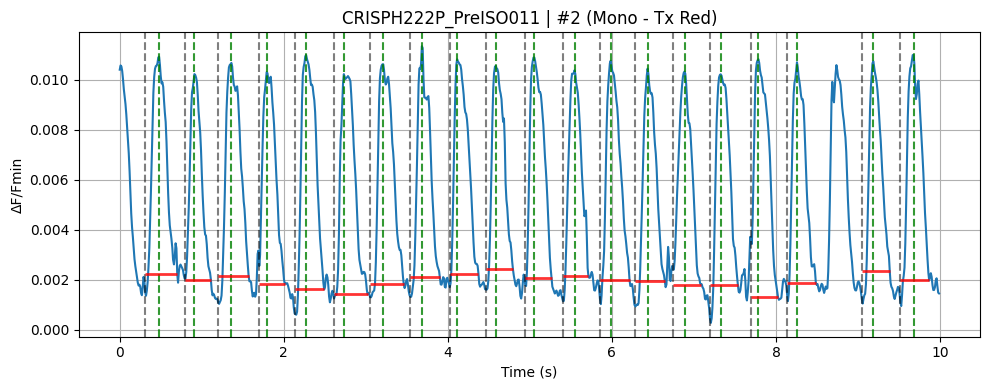

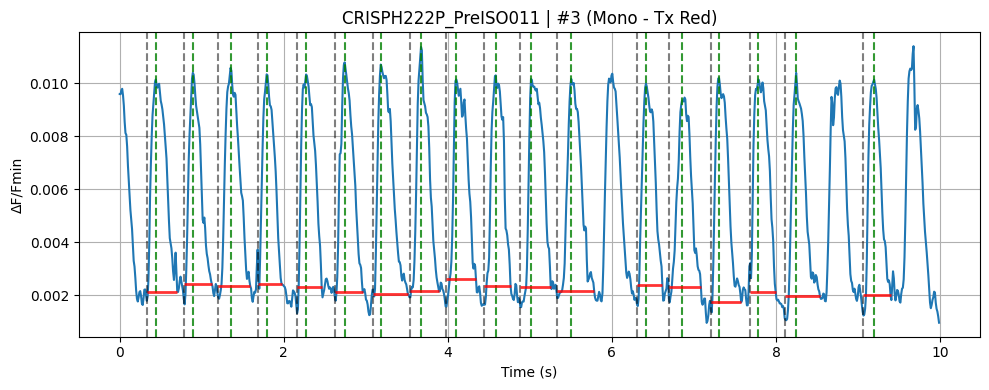

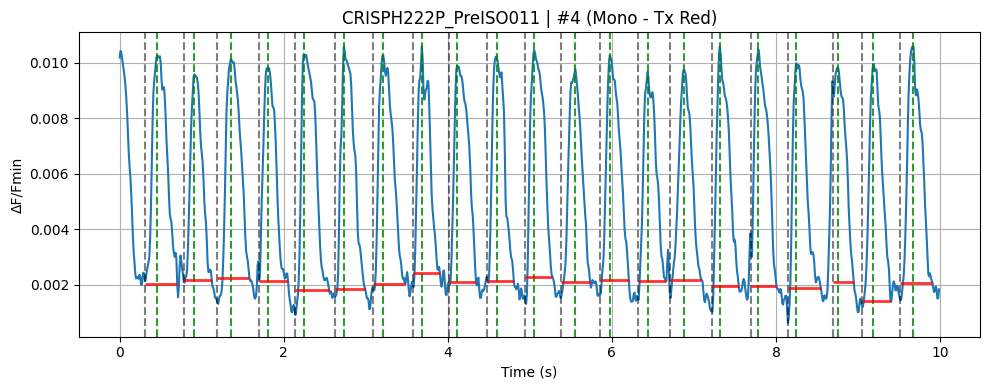

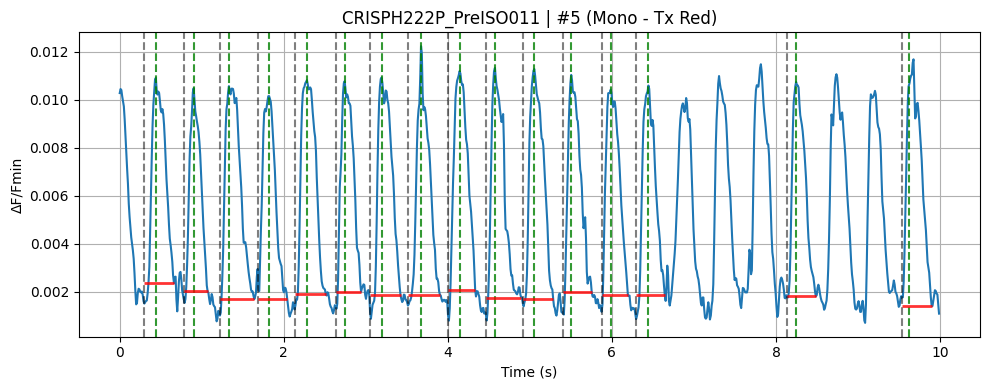

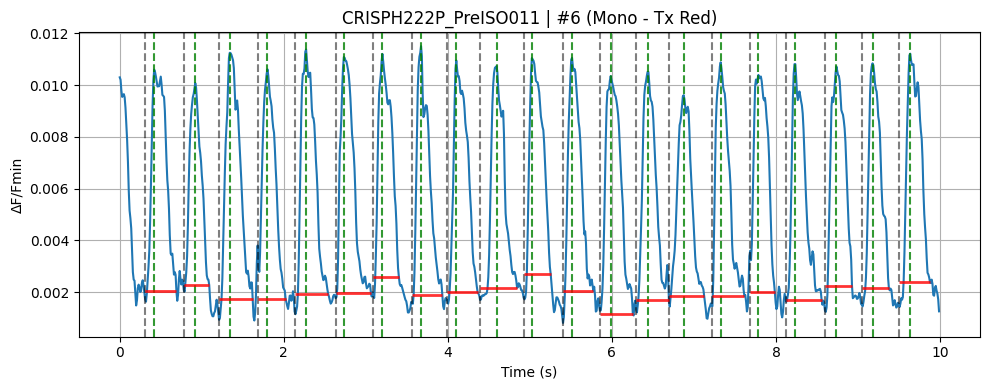

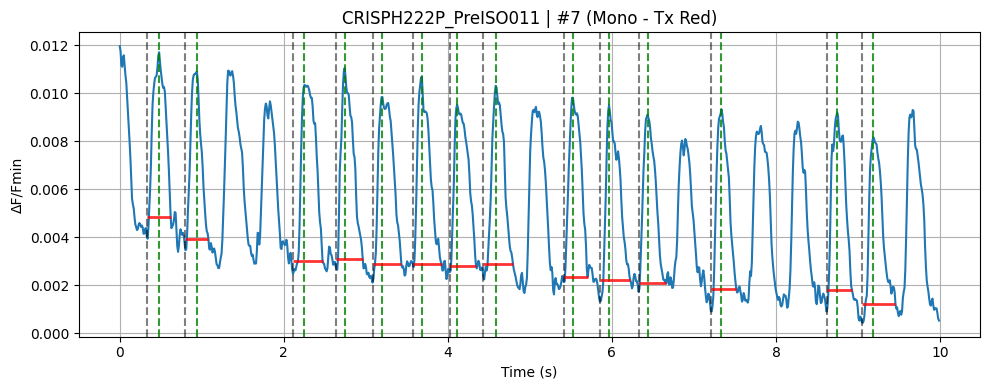

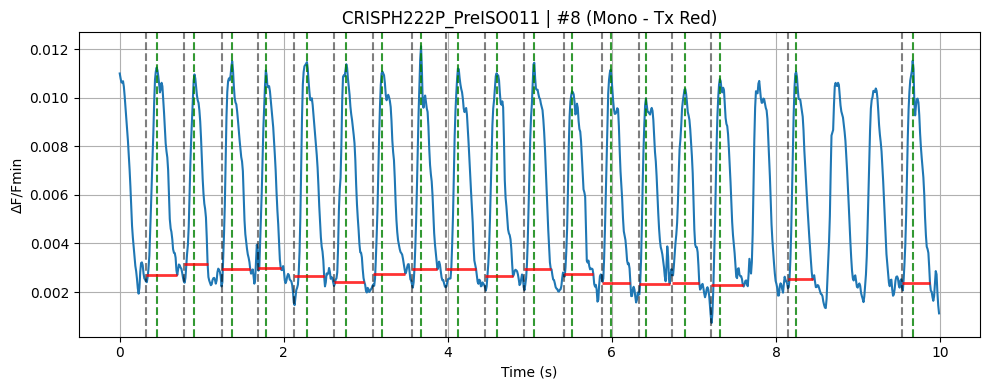

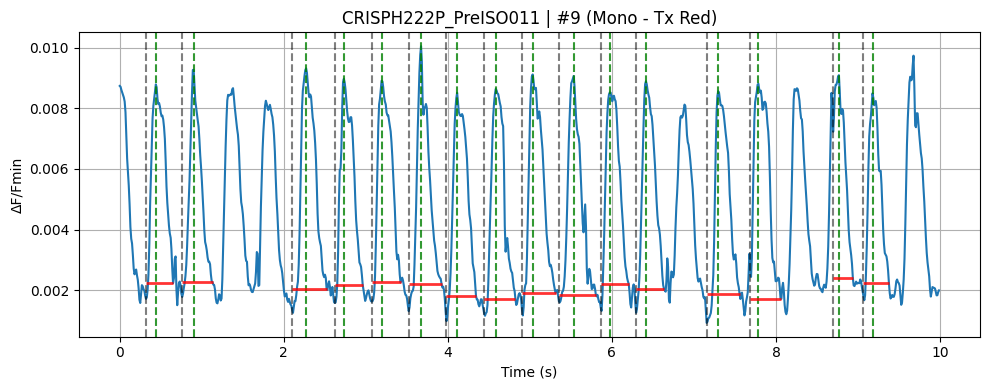

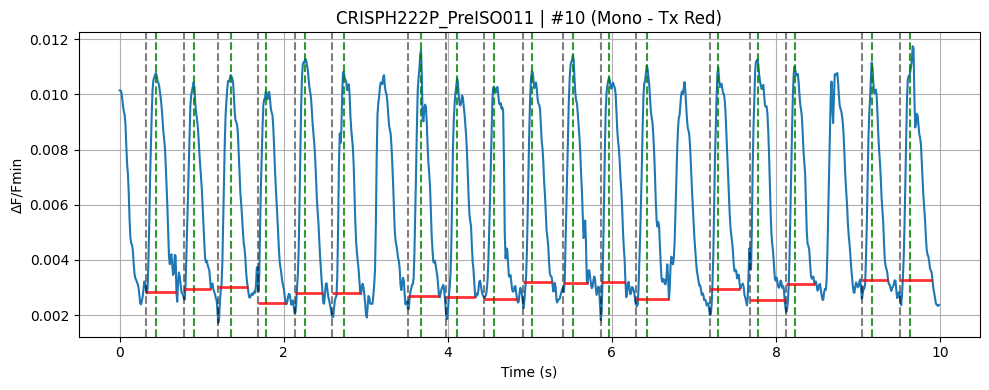

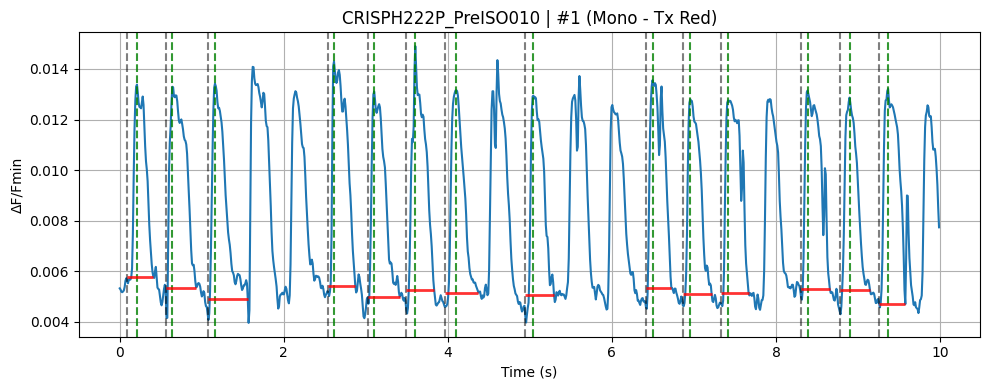

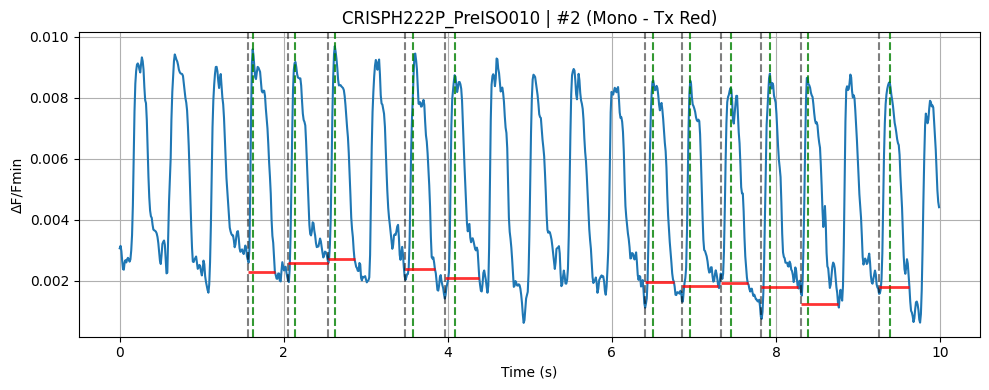

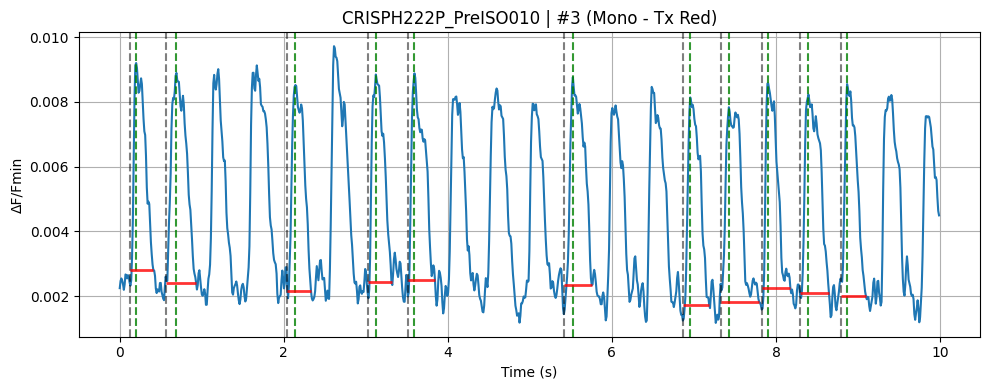

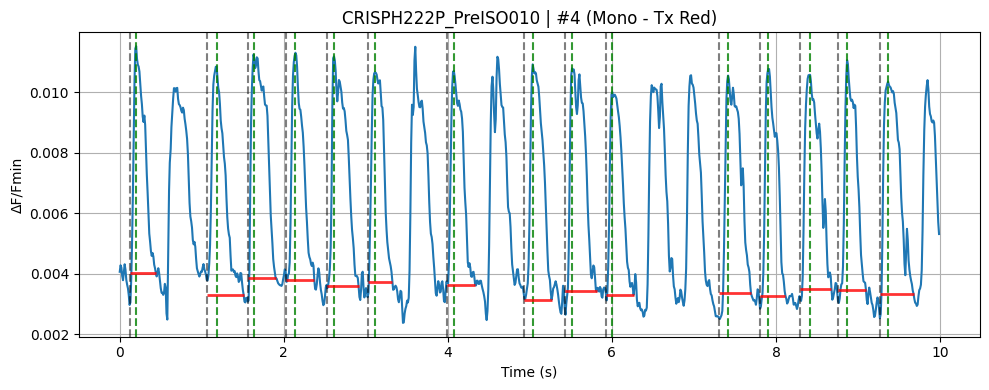

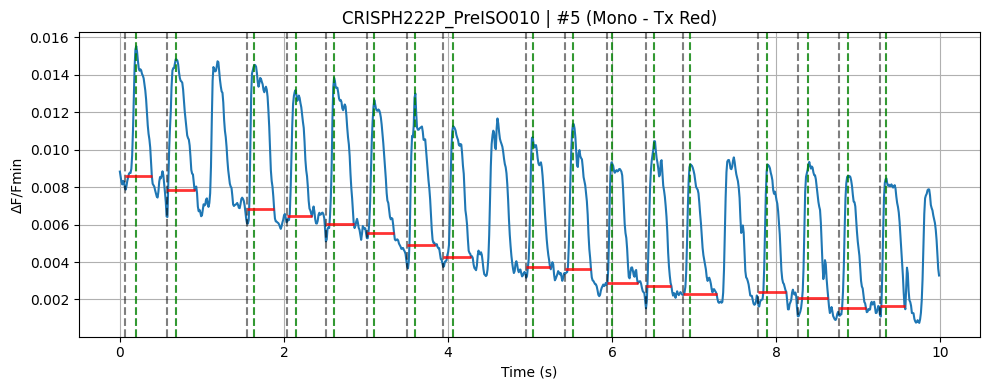

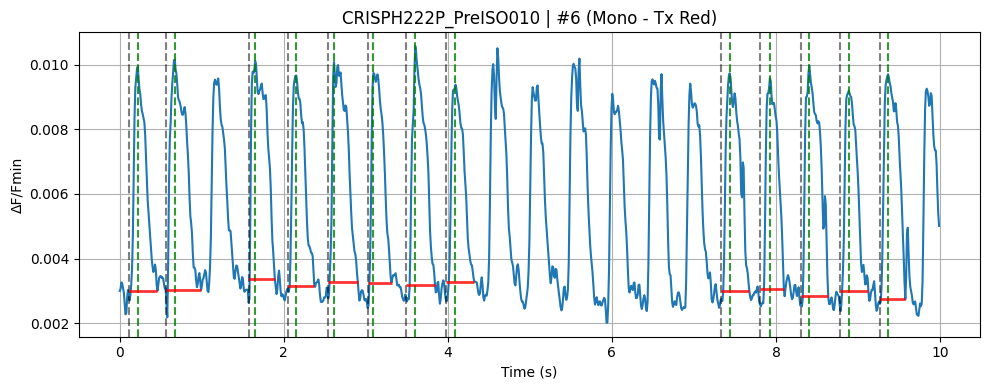

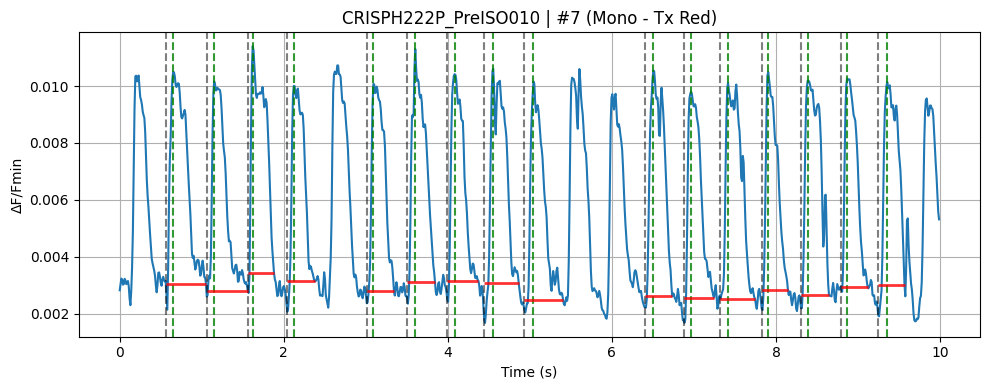

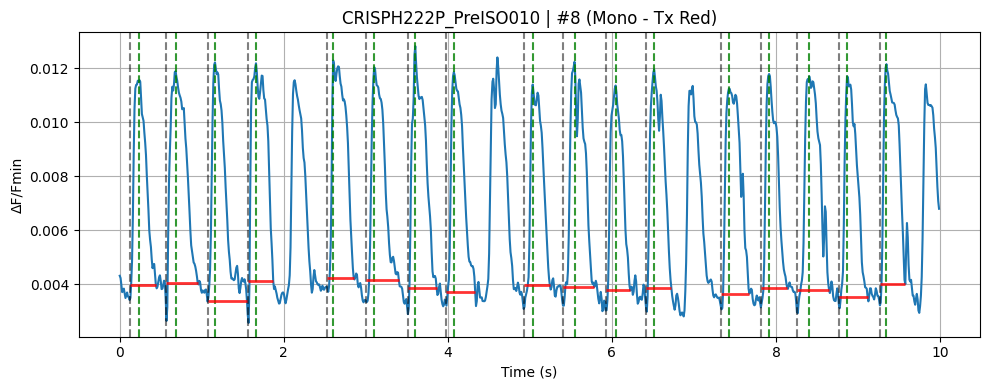

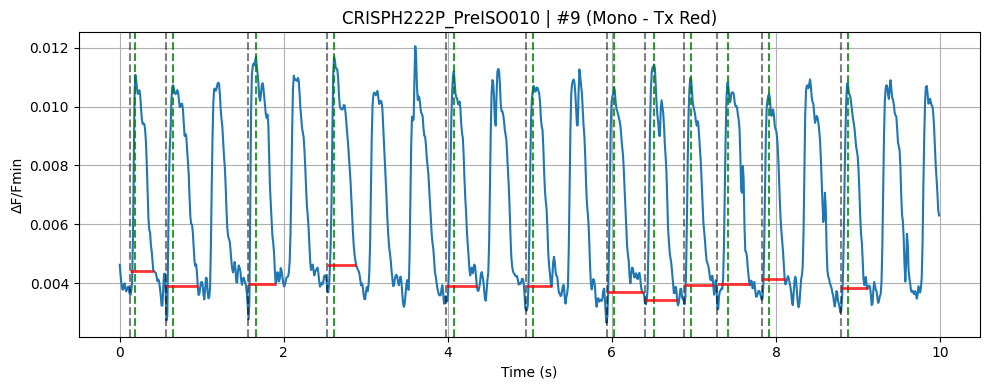

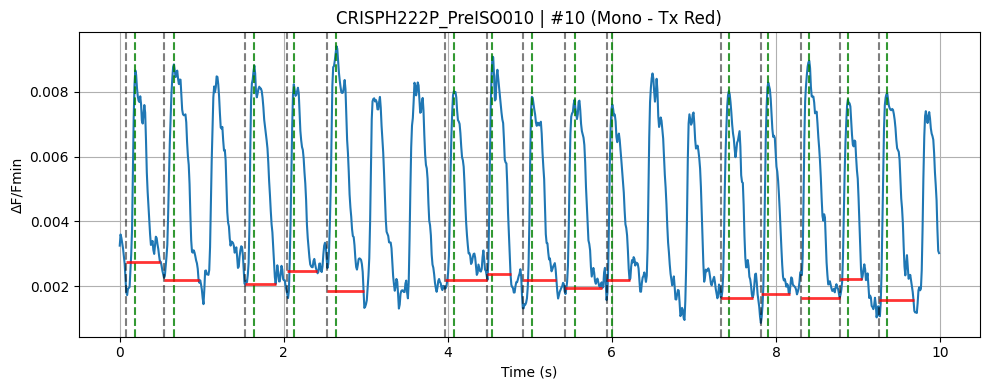

In [8]:
# ─── Cell 5: Main Loop — Call analyze_roi_signal on Each ROI ──────────────
all_results = []
plots = []

for sheet_name in xls.sheet_names:
    # Skip empty or header‐only sheets
    raw = xls.parse(sheet_name, header=None, nrows=1)
    if raw.dropna(how="all").empty:
        continue

    # Derive a sample name
    sample_name = str(raw.iloc[0, 0])
    if sample_name.lower().endswith(".nd2"):
        sample_name = sample_name[:-4]

    # Read the actual data (skip that first header row)
    df = xls.parse(sheet_name, header=1)
    if df.dropna(how="all").empty:
        continue
    df.columns = df.columns.astype(str).str.strip()

    # Identify time & ROI columns
    time_col = [c for c in df.columns if "time" in c.lower()]
    if not time_col:
        continue
    time = pd.to_numeric(df[time_col[0]], errors="coerce").values

    roi_cols = [c for c in df.columns if c != time_col[0] and "Mono" in c]

    # Analyze each ROI
    for roi in roi_cols:
        samp, roi_label, res_df, fig = analyze_roi_signal(
            time, df[roi], sample_name, roi
        )
        res_df.insert(0, "Sample", samp)
        res_df.insert(1, "ROI", roi_label)
        all_results.append(res_df)
        plots.append((samp, roi_label, fig))

In [9]:
# ─── Cell 6: Aggregate & Display Results ───────────────────────────────────
if all_results:
    summary_df = pd.concat(all_results, ignore_index=True)
    # Show full table or save/export as needed
    display(summary_df)
else:
    print("No valid ROI data found in any sheet.")

,Sample,ROI,Depolarization_Start_Time_s,Peak_Time_s,Amplitude,APD50_s,APD90_s,APD50_90_Ratio,Upstroke_Time_s,Repolarization_Time_s,Repolarization_Level
0,SUPH222P_PostISO002,#1 (Mono - Tx Red),0.190,0.280,0.013493,0.320,0.641,0.499220,0.09,0.831,0.016876
1,SUPH222P_PostISO002,#1 (Mono - Tx Red),1.861,1.941,0.011944,0.271,0.351,0.772080,0.08,2.212,0.020116
2,SUPH222P_PostISO002,#1 (Mono - Tx Red),2.862,2.922,0.011550,0.260,0.300,0.866667,0.06,3.162,0.013251
3,SUPH222P_PostISO002,#1 (Mono - Tx Red),3.853,3.923,0.012883,0.290,0.370,0.783784,0.07,4.223,0.007758
4,SUPH222P_PostISO002,#1 (Mono - Tx Red),4.553,4.623,0.000449,0.091,0.111,0.819820,0.07,4.664,0.007095
...,...,...,...,...,...,...,...,...,...,...,...
393,CRISPH222P_PreISO010,#10 (Mono - Tx Red),7.326,7.426,0.007068,0.290,0.390,0.743590,0.10,7.716,0.001642
394,CRISPH222P_PreISO010,#10 (Mono - Tx Red),7.816,7.906,0.007234,0.230,0.350,0.657143,0.09,8.166,0.001767
395,CRISPH222P_PreISO010,#10 (Mono - Tx Red),8.306,8.406,0.008095,0.251,0.471,0.532909,0.10,8.777,0.001630
396,CRISPH222P_PreISO010,#10 (Mono - Tx Red),8.777,8.877,0.005978,0.230,0.270,0.851852,0.10,9.047,0.002204
